# Pregunta 3

Como las preguntas se encuentran separadas en distintos archivos, se baja nuevamente el archivo desde el cual se extrae el Dataframe a ser estudiado.

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm

url = "http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data"
df = pd.read_csv(url, sep="\t", header=0)
df = df.drop("Unnamed: 0", axis=1)
istrain_str = df["train"]
istrain = np.asarray([True if s == "T" else False for s in istrain_str])
istest = np.logical_not(istrain)
df = df.drop("train", axis=1)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled["lpsa"] = df["lpsa"]
X = df_scaled.ix[:,:-1]
N = X.shape[0]
X.insert(X.shape[1], "intercept", np.ones(N))
y = df_scaled["lpsa"]
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

Se ajusta un modelo de regresión lineal utilizando regularización "Ridge Regression", para esto se varía el coeficiente $\lambda$ entre $10^{-1}$ y $10^{4}$. Luego, se crea un gráfico que muestra los pesos de cada variable con respecto al coeficiente $\lambda$ utilizado.

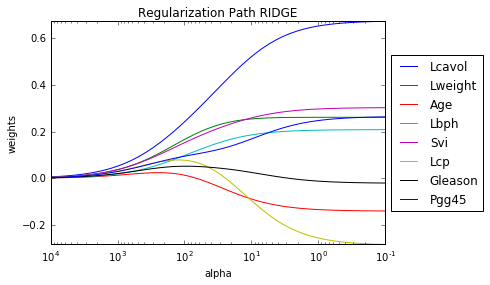

In [12]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt
%matplotlib inline

X = X.drop("intercept", axis=1)
Xtrain = X[istrain]
ytrain = y[istrain]
names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]
alphas_ = np.logspace(4,-1,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver="svd")

for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Regularization Path RIDGE")
plt.axis("tight")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Se observa a primera vista, que para valores $\lambda$ del orden $10^{3}$ y mayor es muy dificil diferenciar los pesos entre las variables. Valores de $\lambda$ del orden $10^{2}$ y menores son útiles para esta diferenciación.

La tendencia del gráfico indica que las variables Lcavol, Svi, Lweight y Lbph son las que poseen mayores pesos, ademas de menor varianza, por lo que pueden ser calificadas como buenos estimadores.

Luego, se realiza el mismo experimento, pero esta vez utilizando la regularización "Lasso", en donde el coeficiente $\lambda$ varía esta vez desde $10^{1}$ a $10^{-2}$. Nuevamente se realiza un gráfico similar a Ridge regression, cuyo resultado es:

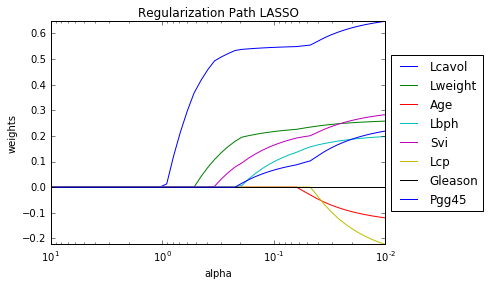

In [20]:
from sklearn.linear_model import Lasso
Xtrain = X[istrain]
ytrain = y[istrain]
names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]
alphas_ = np.logspace(1,-2,base=10)
coefs = []
model = clf = Lasso(fit_intercept=True)

for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)
plt.legend()
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Regularization Path LASSO")
plt.axis("tight")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

En este caso se observa que Lasso funciona solo para valores de $\lambda$ menores a 1, ya que así es posible diferenciar los pesos de las variables.

La tendencia del modelo permite diferenciar que las variables con un mayor peso son Lcavol, Svi y Lweight, tendencia que se mantiene para todos los coeficientes $\lambda$ estudiados. Cabe destacar que se obtuvo la misma conclusión que en el gráfico de Ridge regression.

Por último, si comparamos ambos métodos se puede percibir cierta ventaja al utilizar la regularización Lasso, ya que esta permite la diferenciación de pesos entre las variables de una forma mas clara (gráficamente hablando). De todas formas y como se dijo anteriormente, en Ridge Regression es posible concluir lo mismo, pero requiere una mejor interpretación ya que en el gráfico las variables se ven mas cercanas entre si.

Luego, se realiza un estudio para observar la variación del error cuadrático medio, tanto de entrenamiento como de prueba, con respecto al $\lambda$ para ambos métodos. Para esto se varía este valor entre $10^{2}$ y $10^{-2}$ calculando cada vez el MSE (Error cuadrático medio), y graficando finalmente los resultados. Se realiza primero este experimento para Ridge Regression:

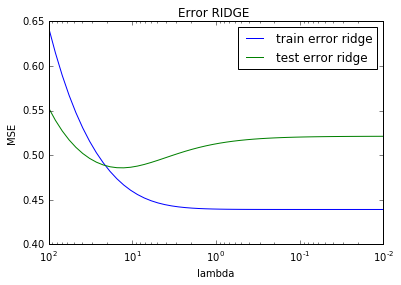

In [22]:
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
alphas_ = np.logspace(2,-2,base=10)
coefs = []
model = Ridge(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    mse_train.append(np.mean(np.power(yhat_train - ytrain, 2)))
    mse_test.append(np.mean(np.power(yhat_test - ytest, 2)))
ax = plt.gca()
ax.plot(alphas_,mse_train,label="train error ridge")
ax.plot(alphas_,mse_test,label="test error ridge")
plt.legend()
ax.set_xscale("log")
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('Error RIDGE ')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

Se observa que el menor Error de test se encuentra aproximadamente en $\lambda = 20$ (en donde el MSE es aproximadamente $0.49$), valor desde el cual empieza a ocurrir un fenómeno de Overfitting, ya que a pesar de que el error de entrenamiento se encuentra disminuyendo, el error de prueba comienza a aumentar, siendo mayor al error de entrenamiento.

Luego, se repite el proceso, pero esta vez utilizando un modelo Lasso, el gráfico es el siguiente:

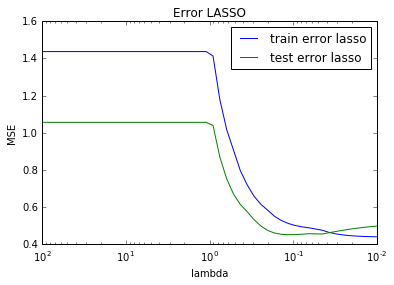

In [23]:
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
alphas_ = np.logspace(-2,2,base=10)
coefs = []
model = Lasso(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    mse_train.append(np.mean(np.power(yhat_train - ytrain, 2)))
    mse_test.append(np.mean(np.power(yhat_test - ytest, 2)))
ax = plt.gca()
ax.plot(alphas_,mse_train,label="train error lasso")
ax.plot(alphas_,mse_test,label="test error lasso")
plt.legend()
ax.set_xscale("log")
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('Error LASSO')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

Nuevamente se puede observar que para $\lambda$ mayores a 1 no se puede obtener una buena conclusión, ya que los errores permanecen constantes. Se observa que a partir de ese valor, entre mas pequeño sea, el valor de ambos errores comienza a decaer. En primera instancia, el error de entrenamiento permanece mayor al de prueba, lo que cambia aproximadamente en $\lambda = 0.03$, sin embargo, esta diferencia es muy pequeña por lo que se puede decir que este método no sobreajusta las variables. Ademas, se puede observar que aproximadamente en $\lambda = 0.2$ se encuentra el menor error cuadrático medio de prueba, el cual es aproximadamente de $0.45$.


Finalmente, se busca encontrar el mejor valor del parámetro de regularización para ambos casos, pero esta vez utilizando cross-validation. El resultado del experimento es:

In [17]:
from sklearn import cross_validation
def MSE(y,yhat): 
    return np.mean(np.power(y-yhat,2))

Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
k_fold = cross_validation.KFold(len(Xm),10)
best_cv_mse = float("inf")
model = Ridge(fit_intercept=True)
for a in alphas_:
    model.set_params(alpha=a)
    mse_list_k10 = [MSE(model.fit(Xm[train], ym[train]).predict(Xm[val]), ym[val]) for train, val in k_fold]
    if np.mean(mse_list_k10) < best_cv_mse:
        best_cv_mse = np.mean(mse_list_k10)
        best_alpha = a
        print "RIDGE: BEST PARAMETER=%f, MSE(CV)=%f"%(best_alpha,best_cv_mse)

RIDGE: BEST PARAMETER=0.010000, MSE(CV)=0.757182
RIDGE: BEST PARAMETER=0.012068, MSE(CV)=0.757171
RIDGE: BEST PARAMETER=0.014563, MSE(CV)=0.757157
RIDGE: BEST PARAMETER=0.017575, MSE(CV)=0.757140
RIDGE: BEST PARAMETER=0.021210, MSE(CV)=0.757120
RIDGE: BEST PARAMETER=0.025595, MSE(CV)=0.757096
RIDGE: BEST PARAMETER=0.030888, MSE(CV)=0.757067
RIDGE: BEST PARAMETER=0.037276, MSE(CV)=0.757033
RIDGE: BEST PARAMETER=0.044984, MSE(CV)=0.756991
RIDGE: BEST PARAMETER=0.054287, MSE(CV)=0.756941
RIDGE: BEST PARAMETER=0.065513, MSE(CV)=0.756881
RIDGE: BEST PARAMETER=0.079060, MSE(CV)=0.756809
RIDGE: BEST PARAMETER=0.095410, MSE(CV)=0.756724
RIDGE: BEST PARAMETER=0.115140, MSE(CV)=0.756622
RIDGE: BEST PARAMETER=0.138950, MSE(CV)=0.756501
RIDGE: BEST PARAMETER=0.167683, MSE(CV)=0.756358
RIDGE: BEST PARAMETER=0.202359, MSE(CV)=0.756189
RIDGE: BEST PARAMETER=0.244205, MSE(CV)=0.755990
RIDGE: BEST PARAMETER=0.294705, MSE(CV)=0.755759
RIDGE: BEST PARAMETER=0.355648, MSE(CV)=0.755492
RIDGE: BEST PARAMETE

In [18]:
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
k_fold = cross_validation.KFold(len(Xm),10)
best_cv_mse = float("inf")
model = Lasso(fit_intercept=True)
for a in alphas_:
    model.set_params(alpha=a)
    mse_list_k10 = [MSE(model.fit(Xm[train], ym[train]).predict(Xm[val]), ym[val]) for train, val in k_fold]
    if np.mean(mse_list_k10) < best_cv_mse:
        best_cv_mse = np.mean(mse_list_k10)
        best_alpha = a
        print "LASSO: BEST PARAMETER=%f, MSE(CV)=%f"%(best_alpha,best_cv_mse)

LASSO: BEST PARAMETER=0.010000, MSE(CV)=0.758661


Tanto para Ridge como para Lasso, se encuentra los mejores valores de $\lambda$ para los cuales se minimiza el MSE. Estos valores son $\lambda_{Ridge} = 2.33$ y $\lambda_{Lasso} = 0.01$, cuyos MSE son respectivamente $MSE_{Ridge}=0.752$ y $MSE_{Lasso}=0.759$.

De los valores obtenidos se puede concluir que en el caso de utilizar Cross Validation, el método que mejor minimiza los errores es Ridge, valores que sin embargo son mayores a los obtenidos en los experimentos pasados, por lo que se puede concluir que Cross Validation no es una buena técnica para estimar los parámetros de regularización